In [3]:
import numpy as np
import foapgb

from scipy.spatial import distance

In [4]:
import matplotlib.pyplot as plt
import io
from PIL import Image, ImageDraw
import numpy as np
from pptx import Presentation
from pptx.util import Inches

# 画像を作成する関数
def create_image(size, shape='circle', color='red', intensity=0.5):
    img = Image.new('RGB', (size, size), (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    # 円形を描画する例
    if shape == 'circle':
        radius = int(size * intensity / 2)
        center = (size // 2, size // 2)
        draw.ellipse([center[0] - radius, center[1] - radius,
                      center[0] + radius, center[1] + radius], fill=color)
    
    return img

# PowerPointのプレゼンテーションを作成
prs = Presentation()

# グリッドのサイズ
grid_size = 11  # 行・列のサイズ
img_size = 60  # 画像のピクセルサイズ
img_path_template = "image_{:02d}_{:02d}.png"  # 画像の保存パス

# スライドを追加
slide_layout = prs.slide_layouts[5]  # 空のレイアウトを選択
slide = prs.slides.add_slide(slide_layout)

# 画像を順に生成し、PowerPointに配置
for i in range(grid_size):
    for j in range(grid_size):
        # 画像を生成
        intensity = (i + j + 1) / (grid_size * 2)  # 色の濃さを変化
        img = create_image(img_size, intensity=intensity)
        
        # 画像をメモリバッファに保存
        img_buffer = io.BytesIO()
        img.save(img_buffer, format="png")
        img_buffer.seek(0)  # バッファの先頭に戻す
        
        # 画像の一時保存
        # img_path = img_path_template.format(i, j)
        # img.save(img_path)

        # PowerPointに画像を追加
        left = Inches(1.5 + j * 0.6)  # 左からの配置位置
        top = Inches(0.3 + i * 0.6)   # 上からの配置位置
        slide.shapes.add_picture(img_buffer, left, top, width=Inches(0.5), height=Inches(0.5))

# PowerPointファイルの保存
prs.save("output_presentation.pptx")
print("PowerPoint presentation saved as 'output_presentation.pptx'.")

PowerPoint presentation saved as 'output_presentation.pptx'.


In [5]:
# Number of columns
Num_Cols = 50

# 格子は0-10に存在するする
Spartial_Scaling = 10/(Num_Cols)

city_network = foapgb.make_lattice(Num_Cols)
K = Num_Cols * Num_Cols

# 通勤費用パラメータ
t = 0.1

# 距離抵抗パラメータ
tau = 0.5

# 労働投入量
L = 1.0

# 総土地供給量は100*100=100とする
Total_S = 100

Coordinate_Data = \
np.array([(city_network['node_dic'][str(i)]['x_pos']*Spartial_Scaling, 
           city_network['node_dic'][str(i)]['y_pos']*Spartial_Scaling) for i in range(K)])
distance_matrix = distance.squareform(distance.pdist(Coordinate_Data))


# theta -> infty = deterministic model 
theta_N = 1.0
theta_M = 1.0

def m_image(prm, m, max_flag=True):
   
    Num_Cols = int(np.sqrt(prm.K))
    mat = np.reshape(m, (Num_Cols, Num_Cols))
    
    plt.figure(figsize=(5,5))
    if max_flag:
        plt.imshow(mat, interpolation='nearest', vmin=0.0, vmax=prm.S.max(), cmap='Reds')
    else:
        plt.imshow(mat, interpolation='nearest', cmap='Reds')
        
    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])
    
    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    plt.close()
    buf.seek(0)
    
    return Image.open(buf)

print('theta_N=', theta_N)
print('theta_M=', theta_M)

print('t=', t)
print('tau=', tau)

theta_N= 1.0
theta_M= 1.0
t= 0.1
tau= 0.5


In [6]:
prm = foapgb.Parameter(K, distance_matrix, t, tau, L, Total_S, theta_M, theta_N)
sub = foapgb.Sub(prm)

master = foapgb.Master(prm, sub, itr_max_sub=10000, err_sub=10**(-3))

In [7]:
# 初期解を均等分布で与える場合
m0 = prm.M * (np.ones(K)/K)

# 初期解をランダムに与える場合
# m0 = master.make_random_m()

In [8]:
%%time
m_hist, F_hist = master.solve(m0=m0, err_mas=10**(-4), max_itr=10000, Lip=1500)

CPU times: total: 1.36 s
Wall time: 1.35 s


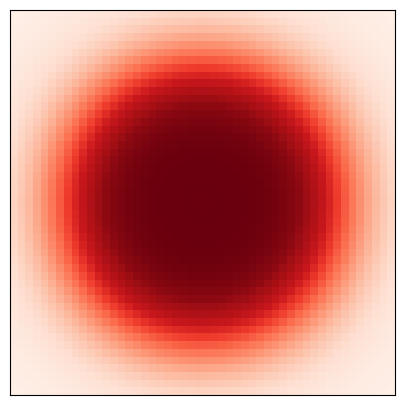

In [9]:
hist_num = len(m_hist)
img = m_image(prm, m_hist[hist_num-1])
img

In [10]:
# 企業の初期立地パターンを設定する関数
def set_initial_pattern(init, alpha=0.0):
    center = [K//2+Col//2, #真ん中（空間の中心）
              0, #左上角
              Col//2, #上端，下端
              K//2, #中央右端，中央左端
              Col//4+K//4, 
              3*Col//4+K//4,
              Col//4+3*K//4,
              3*Col//4+3*K//4,
              Col//4,
              3*Col//4,
              K//4,
              3*K//4,
              Col//2+K//4,
              Col//4+K//2,
              3*Col//4+K//2,
              Col//2+3*K//4]

    firm.fill(0.0)
    
    if init in [-1, -2]:
        # ファイルから読み込み (仮にファイル処理は無視)
        print(f"tau = {tau:.3f}, t = {t:.3f}, 初期立地: ファイルから")
        filename = f"input{-init}.txt"
        try:
            with open(filename, "r") as file:
                for i in range(K):
                    firm[i] = float(file.readline())
        except FileNotFoundError:
            print("File Open Failed.")
            return

    elif init == 0:
        print(f"tau = {tau:.3f}, t = {t:.3f}, 初期立地: 一様分布")
        firm.fill(M/K)

    elif init in [1, 2, 4, 8, 16]:
        print(f"tau = {tau:.3f}, t = {t:.3f}, 初期立地: {init}極集中")
        area = M / S / init
        ai = int(area)
        print("init:", init)
        print("ai:", ai)
        for cnt in range(init):
            i = center[cnt] #iはノード番号
            for y in range(ai):
                j = int(((delta[y] // Col + i // Col) % Col) * Col + (delta[y] % Col + i % Col) % Col)
                print("j:", j)
                firm[j] = S
            
            print("y:", y)
            firm[y] = (area - ai) * S

    elif init == 3:
        print(f"tau = {tau:.3f}, t = {t:.3f}, 初期立地: 二極と四極(a = {alpha})")
        for cnt in range(2):
            i = center[cnt]
            for y in range(int(M / S / 2)):
                j = ((delta[y] // Col + i // Col) % Col) * Col + (delta[y] % Col + i % Col) % Col
                firm[j] += S * (1.0 - alpha)
        for cnt in range(4):
            i = center[cnt]
            for y in range(int(M / S / 4)):
                j = ((delta[y] // Col + i // Col) % Col) * Col + (delta[y] % Col + i % Col) % Col
                firm[j] += S * alpha

    else:
        print(f"tau = {tau:.3f}, t = {t:.3f}, 初期立地: ランダム")
        m = M
        x = S
        random.seed()
        while m > Epsilon:
            i = random.randint(0, K-1)
            if firm[i] <= S - x:
                firm[i] += x
                m -= x

# 距離計算 (仮実装)
def distance(i, j):
    return abs(i - j)

# Z1の計算
def calc_Z1(init):
    Z1 = 0.0
    if init == 0:
        for i in range(K):
            Z1 -= 0.5 * np.exp(-tau * distance(i, 0)) * firm[i] * firm[0]
        Z1 *= K
    elif init in [1, 2, 4, 8, 16]:
        c = K // 2 + Col // 2
        for i in range(K):
            for y in range(int(M / S / init)):
                j = ((delta[y] // Col + c // Col) % Col) * Col + (c % Col + delta[y] % Col) % Col
                Z1 -= 0.5 * np.exp(-tau * distance(i, j)) * firm[i] * firm[j]
        Z1 *= init
    else:
        for i in range(K):
            for j in range(K):
                Z1 -= 0.5 * np.exp(-tau * distance(i, j)) * firm[i] * firm[j]
    return Z1

# 近似目的関数
def rough_potential(init):
    Z1 = calc_Z1(init)
    Z2 = 0.0
    if init == 0:
        Z2 = 0.0
    elif init in [1, 2, 4, 8, 16]:
        Z2 = 0.1165 * t / math.sqrt(init)
    else:
        Z2 = t * obj_sub
    return Z1 + Z2

In [11]:
firm = np.zeros(K)
delta = np.arange(1, K+1)  # 仮の値

In [12]:
set_initial_pattern(init=2)

NameError: name 'Col' is not defined

In [ ]:
#画像を一時保存する場合
import matplotlib.pyplot as plt
import foapgb
import numpy as np
import io
from pptx import Presentation
from PIL import Image
from pptx.util import Inches

def m_image(prm, m, max_flag=True):
   
    Num_Cols = int(np.sqrt(prm.K))
    mat = np.reshape(m, (Num_Cols, Num_Cols))
    
    plt.figure(figsize=(5,5))
    if max_flag:
        plt.imshow(mat, interpolation='nearest', vmin=0.0, vmax=prm.S.max(), cmap='bwr')
    else:
        plt.imshow(mat, interpolation='nearest', cmap='bwr')
        
    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])
    
    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    plt.close()
    buf.seek(0)
    
    return Image.open(buf)


# PowerPointのプレゼンテーションを作成
prs = Presentation()

# グリッドのサイズ
grid_size = 11  # 行・列のサイズ
# img_size = 60  # 画像のピクセルサイズ
img_path_template = "image_{:02d}_{:02d}.png"  # 画像の保存パス

# スライドを追加
slide_layout = prs.slide_layouts[5]  # 空のレイアウトを選択
slide = prs.slides.add_slide(slide_layout)

# 画像を順に生成し、PowerPointに配置
for i in range(grid_size):
    for j in range(grid_size):
        # 画像を生成
        m_hist, F_hist = master.solve(m0=m0, err_mas=10**(-4), max_itr=100, Lip=1500)
        hist_num = len(m_hist)
        img = m_image(prm, m_hist[len(m_hist)-1])
        
        # 画像の一時保存
        img_path = img_path_template.format(i, j)
        img.save(img_path)

        # PowerPointに画像を追加
        left = Inches(1.5 + j * 0.6)  # 左からの配置位置
        top = Inches(0.3 + i * 0.6)   # 上からの配置位置
        slide.shapes.add_picture(img_path, left, top, width=Inches(0.5), height=Inches(0.5))

# PowerPointファイルの保存
prs.save("output_presentation.pptx")
print("PowerPoint presentation saved as 'output_presentation.pptx'.")

In [53]:
%%time
#画像を一時保存しない場合
#exampleのパラメータ，grid=(11, 11)で，3分半くらい．
#theta=50の場合，1画像描画するのに，10分．
import matplotlib.pyplot as plt
import foapgb
import numpy as np
import io
from pptx import Presentation
from PIL import Image
from pptx.util import Inches

def m_image(prm, m, max_flag=True):
   
    Num_Cols = int(np.sqrt(prm.K))
    mat = np.reshape(m, (Num_Cols, Num_Cols))
    
    plt.figure(figsize=(5,5))
    if max_flag:
        plt.imshow(mat, interpolation='nearest', vmin=0.0, vmax=prm.S.max(), cmap='Reds')
    else:
        plt.imshow(mat, interpolation='nearest', cmap='Reds')
        
    plt.gca().invert_yaxis()
    plt.xticks([])
    plt.yticks([])
    
    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    plt.close()
    buf.seek(0)
    
    return buf


# PowerPointのプレゼンテーションを作成
prs = Presentation()

# グリッドのサイズ
grid_size = 3  # 行・列のサイズ
# img_size = 60  # 画像のピクセルサイズ
img_path_template = "image_{:02d}_{:02d}.png"  # 画像の保存パス

# スライドを追加
slide_layout = prs.slide_layouts[5]  # 空のレイアウトを選択
slide = prs.slides.add_slide(slide_layout)

# 画像を順に生成し、PowerPointに配置
for i in range(grid_size):
    for j in range(grid_size):
        # 画像を生成
        m_hist, F_hist = master.solve(m0=m0, err_mas=10**(-4), max_itr=100, Lip=1500)
        hist_num = len(m_hist)
        img_buffer = m_image(prm, m_hist[len(m_hist)-1])

        # PowerPointに画像を追加
        left = Inches(1.5 + j * 0.6)  # 左からの配置位置
        top = Inches(0.3 + i * 0.6)   # 上からの配置位置
        slide.shapes.add_picture(img_buffer, left, top, width=Inches(0.5), height=Inches(0.5))

# PowerPointファイルの保存
prs.save("output_presentation.pptx")
# print("PowerPoint presentation saved as 'output_presentation.pptx'.")

CPU times: total: 15.4 s
Wall time: 15.4 s


In [63]:
A = np.exp(1)
B = np.exp(2)
C = np.exp(3)

In [64]:
A / (A + B + C)

0.09003057317038046

In [65]:
A_dash = np.exp(-2)
B_dash = np.exp(-1)
C_dash = np.exp(0)

In [66]:
A_dash / (A_dash + B_dash + C_dash)

0.09003057317038046